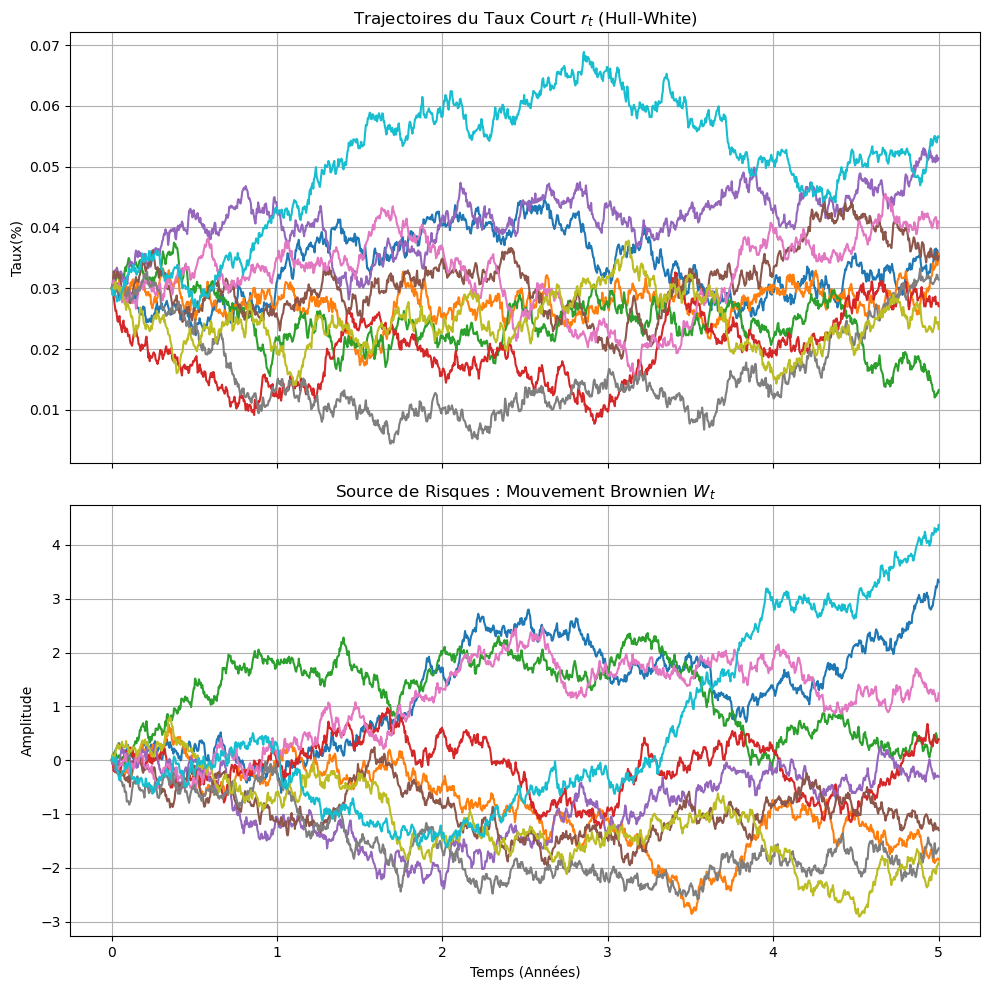

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def hull_white_simulation_with_bm(r0,a, sigma, T, dt, forward_rates):
    n_steps = int(T/dt)
    n_paths = 1000

    #Initialisation des matrices
    rates = np.zeros((n_steps, n_paths))
    brownian_motion = np.zeros((n_steps, n_paths))

    rates[0]=r0
    brownian_motion[0]=0

    time_grid = np.linspace(0,T,n_steps)

    for t in range(1, n_steps):
        standard_normal=np.random.normal(0,1,n_paths)
        dW=np.sqrt(dt)*standard_normal

        brownian_motion[t]=brownian_motion[t-1]+dW

        drift=a*(forward_rates[t]-rates[t-1])*dt
        diffusion=sigma*dW

        rates[t]=rates[t-1]+drift+diffusion
        
    return time_grid, rates, brownian_motion

#Paramères
r0,a,sigma,T,dt = 0.03,0.1,0.01,5,1/252
forward_rates=np.full(int(T/dt),0.035)

time_grid,paths_r,paths_W=hull_white_simulation_with_bm(r0,a,sigma,T,dt,forward_rates)

#Visualisation double
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10),sharex=True)

#Graphique 1 : Taux d'intérêt court-terme r(t)
indices_au_hasard=np.random.choice(1000,10,replace=False)
ax1.plot(time_grid,paths_r[:,indices_au_hasard])
ax1.set_title("Trajectoires du Taux Court $r_t$ (Hull-White)")
ax1.set_ylabel("Taux(%)")
ax1.grid(True)

#Graphique 2 : Mouvement Brownien W(t)
ax2.plot(time_grid,paths_W[:,:10])
ax2.set_title("Source de Risques : Mouvement Brownien $W_t$")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Temps (Années)")
ax2.grid(True)

plt.tight_layout()
plt.show()

In [2]:
#Pricing d'un Caplet par Monte Carlo
#Paramètre de l'option
T_opt=1.0 # Maturité de l'option (1 ans)
strike = 0.035 # Strike à 3.5%
n_steps_opt = int(T_opt/dt)

#On récupère les taux à l'échéance T_opt pour toutes les trajectoires
r_at_T=paths_r[n_steps_opt - 1, :]

#Calcul du payoff pour chaque trajectoire : Max(r_t - Strike, 0)
payoffs=np.maximum(r_at_T - strike, 0)

#Calcul du facteur d'actualisation stochastique pour chaque trajectoire (cad on some les taux r_t sur chaque chemin jusqu'à T-opt)
integral_r = np.sum(paths_r[:n_steps_opt,:],axis=0)*dt
discount_factors=np.exp(-integral_r)

#Le prix est la moyenne des Payoffs*Discount Factors
option_price = np.mean(payoffs*discount_factors)

print(f"Moyenne de r_at_T :{np.mean(r_at_T)}")
print(f"Prix du Caplet (Strike {strike*100}%): {option_price*10000:.2f}bps")
print(f"Nombre de trajectoires 'In-the-money':{np.sum(payoffs>0)}")


Moyenne de r_at_T :0.031052343234076026
Prix du Caplet (Strike 3.5000000000000004%): 20.04bps
Nombre de trajectoires 'In-the-money':333


In [3]:
import numpy as np
import matplotlib.pyplot as plt

#Paramètres Taux
r0=0.03
a=0.1
sigma_r=0.01
T=1.0
dt=1/252
n_steps=int(T/dt)
n_paths=1000
forward_rates=np.full(n_steps,0.035) #Courbe forward cible

#Paramètres Action (Equity)
S0=100.0
sigma_s=0.2
rho=0.3 #Corrélation Taux/Action

#Simulation hybride corrélé
rates=np.zeros((n_steps,n_paths))
S=np.zeros((n_steps,n_paths))
rates[0]=r0
S[0]=S0

for t in range(1,n_steps):
    #Génération des chocs corrélés avec la méthode de Cholesky
    eps_r=np.random.normal(0,1,n_paths)
    eps_s_independent=np.random.normal(0,1,n_paths)
    
    #Choc taux
    dW=np.sqrt(dt)*eps_r
    #Choc action (corrélé à dW à hauteur de rho)
    dZ = np.sqrt(dt)*(rho*eps_r+np.sqrt(1-rho**2)*eps_s_independent)

    #Rappel Taux Hull-White
    drift_r=a*(forward_rates[t]-rates[t-1])*dt
    rates[t]=rates[t-1]+drift_r+sigma_r*dW

    #Action avec Black-Scholes avec taux sto (on utilise donc le taux simulé rates[t-1] comme taux sans risque instantané)
    S[t]=S[t-1]*np.exp((rates[t-1]-0.5*sigma_s**2)*dt+sigma_s*dZ)

#Pricing de la Note à capital garanti

#Calcul du facteur d'actualisation sto (D)
integral_r=np.sum(rates, axis=0)*dt
discount_factors=np.exp(-integral_r)

#Calcul du payoff à l'échéance 
S_T=S[-1,:]
performance=np.maximum((S_T - S0)/S0,0)
payoff_final = S0*(1+performance)

#Valeur présente (moyenne des payoffs actualisés)
price_note=np.mean(payoff_final*discount_factors)

print(f"Moyenne des taux finaux (Check Drift):{np.mean(rates[-1,:])*100:.2f}%")
print(f"Prix de la Note:{price_note:.2f}EUR")
print(f"Valeur de l'option seule (Equity part):{(price_note - np.mean(S0*discount_factors)):.2f}EUR")
    
    

Moyenne des taux finaux (Check Drift):3.05%
Prix de la Note:106.24EUR
Valeur de l'option seule (Equity part):9.21EUR
